# Pneumonia Classification on TPU

<hr />

### Introduction + Set-up

This tutorial will explain how to build an X-ray image classification model to predict whether an X-ray scan shows presence of pneumonia.

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

2025-04-19 04:33:36.361179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745037216.517768      35 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745037216.563932      35 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745037216.933995      35 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745037216.934071      35 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745037216.934078      35 computation_placer.cc:177] computation placer alr

Number of replicas: 1


We need a Google Cloud link to our data to load the data using a TPU. Below, we define key configuration parameters we'll use in this example. To run on TPU, this example must be on Colab with the TPU runtime selected.

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

<hr />

### Load the data

The Chest X-ray data we are using from <a href="https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5">Cell</a> divides the data into training and test files. Let's first load in the training TFRecords.

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

2025-04-19 04:33:41.924459: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Let's count how many healthy/normal chest X-rays we have and how many pneumonia chest X-rays we have:

In [4]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

2025-04-19 04:33:42.029649: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-04-19 04:33:42.133378: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".
2025-04-19 04:33:42.962152: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Normal images count in training set: 1349
Pneumonia images count in training set: 3883


2025-04-19 04:33:43.644691: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice that there are way more images that are classified as pneumonia than normal. This shows that we have an imbalance in our data. We will correct for this imbalance later on in our notebook.

We want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.

As we only have two labels, we will encode the label so that 1 or True indicates pneumonia and 0 or False indicates normal.

In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

Let's split the data into a training and validation datasets.

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

Let's visualize the shape of an (image, label) pair.

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

2025-04-19 04:33:55.242962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 236 of 10000
2025-04-19 04:34:15.200907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 990 of 10000
2025-04-19 04:34:25.410663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1307 of 10000


Image shape:  (180, 180, 3)
Label:  0


2025-04-19 04:34:43.787210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 5149 of 10000
2025-04-19 04:34:43.839800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Load and format the test data as well.

In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

<hr />

### Visualize the dataset

First, let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

Please note that large image datasets should not be cached in memory. We do it here because the dataset is not very large and we want to train on TPU.

In [9]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

2025-04-19 04:34:54.706427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 346 of 10000
2025-04-19 04:35:14.887615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1202 of 10000
2025-04-19 04:35:32.077671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-04-19 04:35:32.080116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Define the method to show the images in the batch.

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in NumPy arrays as its parameters, call the numpy function on the batches to return the tensor in NumPy array form.

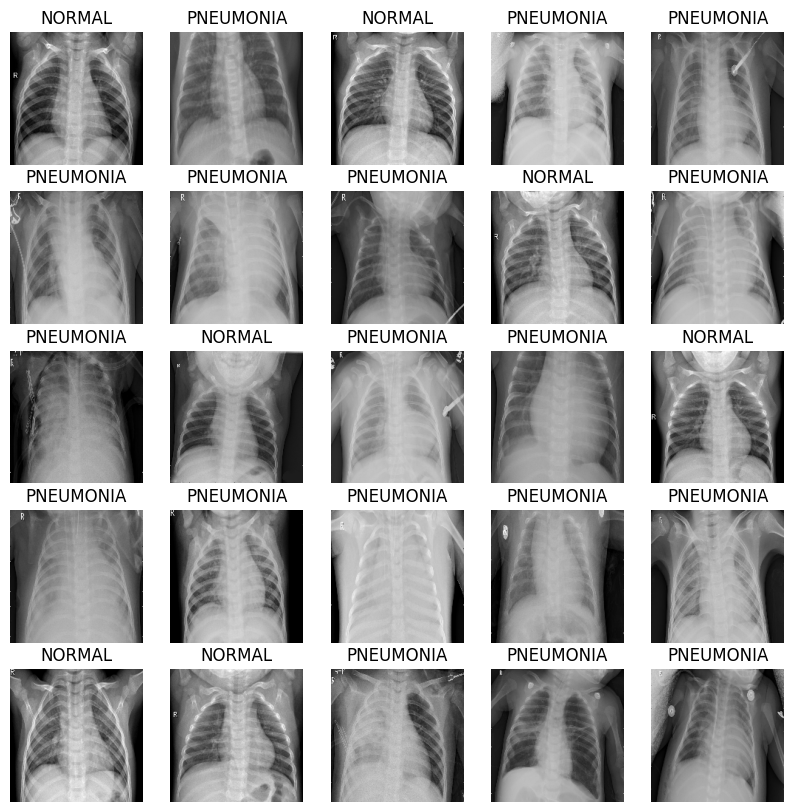

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())

<hr />

### Build the CNN

To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block.

The architecture for this CNN has been inspired by this <a href="https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8">article</a>.

In [13]:
import os 
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

The following method will define the function to build our model for us.

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down for our input.

The Dropout layers are important, as they reduce the likelikhood of the model overfitting. We want to end the model with a Dense layer with one node, as this will be the binary output that determines if an X-ray shows presence of pneumonia.

In [14]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

<hr />

### Correct for data imbalance

We saw earlier in this example that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that by using class weighting:

In [15]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


The weight for class 0 (Normal) is a lot higher than the weight for class 1 (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

<hr />

### Train the model

#### Defining callbacks

The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting.

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

We also want to tune our learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [17]:
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

#### Fit the model

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fraction of the labels is correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

Since there are only two possible labels for the image, we will be using the binary crossentropy loss. When we fit the model, remember to specify the class weights, which we defined earlier. Because we are using a TPU, training will be quick - less than 2 minutes.

In [18]:
with strategy.scope():
    model = build_model()

    METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


2025-04-19 05:08:37.944715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 346 of 10000
2025-04-19 05:08:56.322447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 990 of 10000
2025-04-19 05:09:06.593366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1307 of 10000
2025-04-19 05:09:18.745320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 3314 of 10000
2025-04-19 05:09:24.200263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


    168/Unknown 157s 555ms/step - binary_accuracy: 0.6739 - loss: 0.6324 - precision: 0.8659 - recall: 0.6451

2025-04-19 05:10:57.565020: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2025-04-19 05:11:09.400328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 346 of 10000
2025-04-19 05:11:31.410857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1202 of 10000
2025-04-19 05:11:48.573651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 502

168/168 ━━━━━━━━━━━━━━━━━━━━ 212s 890ms/step - binary_accuracy: 0.6745 - loss: 0.6314 - precision: 0.8663 - recall: 0.6458 - val_binary_accuracy: 0.7209 - val_loss: 17.1861 - val_precision: 0.7209 - val_recall: 1.0000
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 98s 580ms/step - binary_accuracy: 0.8687 - loss: 0.3120 - precision: 0.9601 - recall: 0.8573 - val_binary_accuracy: 0.8411 - val_loss: 0.4905 - val_precision: 0.9693 - val_recall: 0.8051
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - binary_accuracy: 0.9162 - loss: 0.2145 - precision: 0.9720 - recall: 0.9121

2025-04-19 05:15:03.898229: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 98s 582ms/step - binary_accuracy: 0.9163 - loss: 0.2145 - precision: 0.9720 - recall: 0.9121 - val_binary_accuracy: 0.6812 - val_loss: 1.1121 - val_precision: 0.9976 - val_recall: 0.5591
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 98s 586ms/step - binary_accuracy: 0.9303 - loss: 0.1729 - precision: 0.9839 - recall: 0.9207 - val_binary_accuracy: 0.8547 - val_loss: 0.4407 - val_precision: 0.9967 - val_recall: 0.8011
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 587ms/step - binary_accuracy: 0.9185 - loss: 0.2016 - precision: 0.9780 - recall: 0.9096 - val_binary_accuracy: 0.7209 - val_loss: 9.9039 - val_precision: 0.7209 - val_recall: 1.0000
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 98s 584ms/step - binary_accuracy: 0.9297 - loss: 0.1823 - precision: 0.9819 - recall: 0.9214 - val_binary_accuracy: 0.5223 - val_loss: 1.2880 - val_precision: 0.9922 - val_recall: 0.3401
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - binary_accuracy: 0.9104 - loss: 0.2093 - pr

2025-04-19 05:21:37.522723: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 589ms/step - binary_accuracy: 0.9105 - loss: 0.2093 - precision: 0.9739 - recall: 0.9024 - val_binary_accuracy: 0.9438 - val_loss: 0.1572 - val_precision: 0.9971 - val_recall: 0.9247
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 100s 592ms/step - binary_accuracy: 0.9346 - loss: 0.1591 - precision: 0.9832 - recall: 0.9269 - val_binary_accuracy: 0.9079 - val_loss: 0.2211 - val_precision: 0.9969 - val_recall: 0.8750
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 591ms/step - binary_accuracy: 0.9470 - loss: 0.1454 - precision: 0.9853 - recall: 0.9421 - val_binary_accuracy: 0.8789 - val_loss: 0.2924 - val_precision: 0.9968 - val_recall: 0.8347
Epoch 10/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 602ms/step - binary_accuracy: 0.9445 - loss: 0.1393 - precision: 0.9857 - recall: 0.9386 - val_binary_accuracy: 0.9312 - val_loss: 0.1743 - val_precision: 0.9912 - val_recall: 0.9126
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 102s 605ms/step - binary_accuracy: 0.9459 - loss: 0.136

2025-04-19 05:35:02.892251: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 587ms/step - binary_accuracy: 0.9603 - loss: 0.1012 - precision: 0.9898 - recall: 0.9562 - val_binary_accuracy: 0.7955 - val_loss: 0.4262 - val_precision: 0.7791 - val_recall: 1.0000
Epoch 16/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 589ms/step - binary_accuracy: 0.9342 - loss: 0.1683 - precision: 0.9803 - recall: 0.9291 - val_binary_accuracy: 0.9545 - val_loss: 0.1051 - val_precision: 0.9665 - val_recall: 0.9704
Epoch 17/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 591ms/step - binary_accuracy: 0.9328 - loss: 0.1697 - precision: 0.9788 - recall: 0.9290 - val_binary_accuracy: 0.9147 - val_loss: 0.2392 - val_precision: 1.0000 - val_recall: 0.8817
Epoch 18/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 590ms/step - binary_accuracy: 0.9542 - loss: 0.1206 - precision: 0.9884 - recall: 0.9487 - val_binary_accuracy: 0.9632 - val_loss: 0.1108 - val_precision: 0.9669 - val_recall: 0.9825
Epoch 19/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 590ms/step - binary_accuracy: 0.9572 - loss: 0.1142

2025-04-19 06:01:47.320272: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 603ms/step - binary_accuracy: 0.9679 - loss: 0.0958 - precision: 0.9916 - recall: 0.9647 - val_binary_accuracy: 0.9147 - val_loss: 0.2222 - val_precision: 0.9970 - val_recall: 0.8844
Epoch 32/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 603ms/step - binary_accuracy: 0.9684 - loss: 0.0850 - precision: 0.9943 - recall: 0.9626 - val_binary_accuracy: 0.9157 - val_loss: 0.2114 - val_precision: 0.8963 - val_recall: 0.9987
Epoch 33/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 599ms/step - binary_accuracy: 0.9785 - loss: 0.0621 - precision: 0.9942 - recall: 0.9766 - val_binary_accuracy: 0.8672 - val_loss: 0.3764 - val_precision: 0.8469 - val_recall: 0.9960
Epoch 34/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 601ms/step - binary_accuracy: 0.9708 - loss: 0.0760 - precision: 0.9926 - recall: 0.9674 - val_binary_accuracy: 0.9729 - val_loss: 0.0672 - val_precision: 1.0000 - val_recall: 0.9624
Epoch 35/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 600ms/step - binary_accuracy: 0.9717 - loss: 0

2025-04-19 06:55:54.944848: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 102s 605ms/step - binary_accuracy: 0.9820 - loss: 0.0580 - precision: 0.9927 - recall: 0.9827 - val_binary_accuracy: 0.9845 - val_loss: 0.0517 - val_precision: 0.9986 - val_recall: 0.9798
Epoch 64/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 102s 606ms/step - binary_accuracy: 0.9886 - loss: 0.0312 - precision: 0.9973 - recall: 0.9871 - val_binary_accuracy: 0.9758 - val_loss: 0.0701 - val_precision: 1.0000 - val_recall: 0.9664


<hr />

### Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

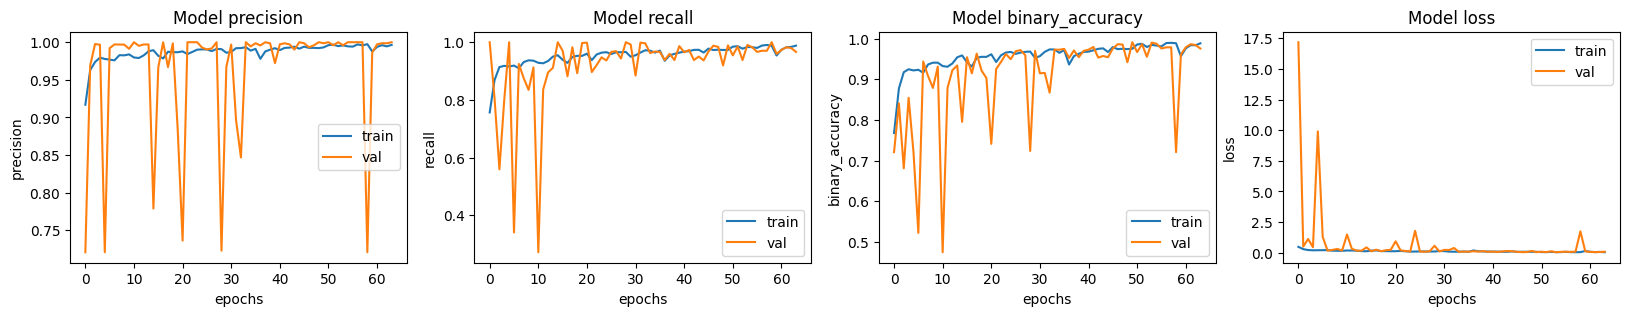

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

We see that the accuracy for our model is around 95%.

<hr />

#### Predict and evaluate results

Let's evaluate the model on our test data!

In [20]:
model.evaluate(test_ds, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - binary_accuracy: 0.5865 - loss: 1.6394 - precision: 0.3608 - recall: 0.6523


{'binary_accuracy': 0.7804487347602844,
 'loss': 0.9200339913368225,
 'precision': 0.7409523725509644,
 'recall': 0.9974358677864075}

We see that our accuracy on our test data is lower than the accuracy for our validating set. This may indicate overfitting.

Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified. We should aim to increase our precision.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
This image is 20.34 percent NORMAL
This image is 79.66 percent PNEUMONIA


/tmp/ipykernel_35/2593322727.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent %s" % ((100 * score), name))


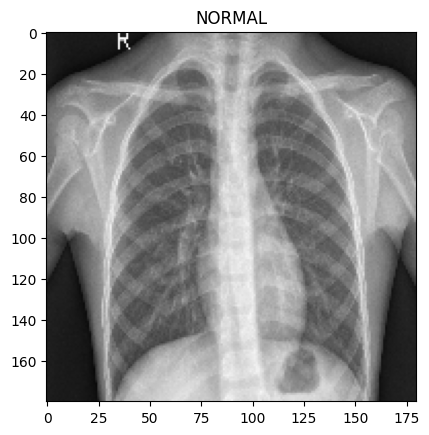

In [21]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))